## Exploratory Analysis of Reproduced Results

In [127]:
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
search_path = "./"
file_extension = "*.csv"

dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

df_orig = pd.concat(dfs, ignore_index=True)
df_orig['Accuracy'] = df_orig['Accuracy'].apply(lambda x: x*100)
df_orig['Original_CI'] = df_orig.Original_CI.apply(lambda x: literal_eval(x))
df_orig['Orig_CI_Low'], df_orig['Orig_CI_Hi'] = zip(*df_orig.Original_CI)

In [70]:
df_orig

,Model,Testset,Epoch,Loss,Accuracy,Original_Accuracy,Original_CI,Orig_CI_Low,Orig_CI_Hi
0,resnext_29_4x64d,cifar10,100,0.6746,80.19,96.4,"(96.0, 96.7)",96.0,96.7
1,resnext_29_4x64d,cifar10,200,0.2311,93.21,96.4,"(96.0, 96.7)",96.0,96.7
2,resnext_29_4x64d,cifar10,300,0.1517,95.35,96.4,"(96.0, 96.7)",96.0,96.7
3,densenet_BC_100_12,cifar10,100,0.3681,88.75,95.5,"(95.1, 95.9)",95.1,95.9
4,densenet_BC_100_12,cifar10,200,0.2279,94.56,95.5,"(95.1, 95.9)",95.1,95.9
5,densenet_BC_100_12,cifar10,300,0.2223,94.84,95.5,"(95.1, 95.9)",95.1,95.9
6,resnet_basic_32,cifar10,100,0.3604,91.70,92.5,"(92.0, 93.0)",92.0,93.0
7,resnet_basic_32,cifar10,160,0.4011,92.32,92.5,"(92.0, 93.0)",92.0,93.0


In [67]:

df_orig.Original_CI.apply(lambda x: literal_eval(x))

0    (96.0, 96.7)
1    (96.0, 96.7)
2    (96.0, 96.7)
3    (95.1, 95.9)
4    (95.1, 95.9)
5    (95.1, 95.9)
6    (92.0, 93.0)
7    (92.0, 93.0)
Name: Original_CI, dtype: object

#### Visualize the delta between our reproduced result and the original result published for the respective model.

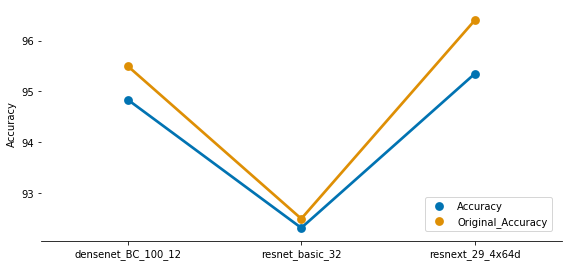

In [76]:
# Get accuracy score of last epoch for each model type
final_score = df_orig[df_orig.groupby(['Model'])['Epoch'].transform(max) == df_orig['Epoch']]

final_score_subset = final_score[['Model', 'Accuracy', 'Original_Accuracy']].sort_values(by=['Model'])
                                 #'Orig_CI_Low', 'Orig_CI_Hi']]

fss_melt = final_score_subset.melt('Model', var_name='cols',  value_name='vals')
g = sns.catplot(x="Model", y="vals", hue='cols', data=fss_melt, kind='point', 
                height=4, aspect=2, palette="colorblind",legend_out=False)

(g.set_axis_labels("", "Accuracy")
  .set_xticklabels(rotation=0)
  .despine(left=True))  
g.add_legend(loc='lower right', borderaxespad=1)
pass

#### Do our models seem to error in the same way?

In [202]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels = testset.targets

# Return a dataframe that contains the classification report for the predictions
classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels == zfile['labels']), "of", len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, labels, target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


In [207]:
def error_by_r_score(zfile):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()[-1 * number_to_analyze:]

    for mi in max_r_value_indexes:
        print("-- R Ratio:", r[mi], " ( index", mi, ")\n   Guessed Label:", zfile['labels'][mi], 
              "\n   Correct Label:", test_labels[mi], "\n   Class Probs:", zfile['probs'][mi], "\n")
        img=Image.fromarray(testset.data[mi])
        images_to_print.append(img)
        


    # Print the misclassified images
    fig = plt.figure(figsize=(16, 4))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        
    return max_r_value_indexes

#### Densenet 

In [203]:
output = './densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
print("Available data:", npzfile.files)
print("\n Acc:", npzfile['acc'], "\nLoss:", npzfile['loss'])
preds = npzfile['preds']
probs = npzfile['probs']
labels = npzfile['labels']

confirm_score(npzfile)

Available data: ['preds', 'probs', 'labels', 'loss', 'acc']

 Acc: 0.9484 
Loss: 0.22231132700443268

Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.951244  0.9560  0.953616   1000.0000
1 automobile   0.971087  0.9740  0.972541   1000.0000
2 bird         0.955533  0.9240  0.939502   1000.0000
3 cat          0.899288  0.8840  0.891578   1000.0000
4  deer        0.937683  0.9630  0.950173   1000.0000
5 dog          0.898354  0.9280  0.912937   1000.0000
6 frog         0.966000  0.9660  0.966000   1000.0000
7 horse        0.983673  0.9640  0.973737   1000.0000
8 ship         0.954769  0.9710  0.962816   1000.0000
9 truck        0.968528  0.9540  0.961209   1000.0000
accuracy       0.948400  0.9484  0.948400      0.9484
macro avg      0.948616  0.9484  0.948411  10000.0000
weighted avg   0.948616  0.9484  0.948411  10000.0000


-- R Ratio: 75146.43  ( index 5830 )
   Guessed Label: 3 
   Correct Label: 5 
   Class Probs: [4.6590742e-10 3.4380457e-07 5.7846825e-09 9.9998629e-01 1.5234178e-09
 1.3307170e-05 4.5507040e-10 1.3015530e-09 3.9456743e-10 7.3355602e-09] 

-- R Ratio: 91149.44  ( index 1969 )
   Guessed Label: 9 
   Correct Label: 1 
   Class Probs: [5.6721942e-06 1.0966472e-05 9.3598924e-09 1.4922101e-08 3.9816868e-08
 1.4080071e-07 8.2582727e-07 3.9247659e-04 2.1952026e-06 9.9958771e-01] 

-- R Ratio: 97676.484  ( index 5511 )
   Guessed Label: 6 
   Correct Label: 3 
   Class Probs: [8.0893547e-10 8.6297734e-07 5.7008652e-05 1.0237106e-05 5.5011050e-08
 3.0940381e-08 9.9992454e-01 1.0574610e-08 2.1037634e-07 7.1299728e-06] 

-- R Ratio: 128654.875  ( index 8728 )
   Guessed Label: 5 
   Correct Label: 6 
   Class Probs: [7.92525101e-10 3.39370246e-07 1.15334814e-07 4.70935833e-03
 3.46262453e-07 9.95281160e-01 7.73605461e-06 4.53010855e-08
 2.65394675e-07 5.96678660e-07] 

-- R Ratio: 152582.98  ( i

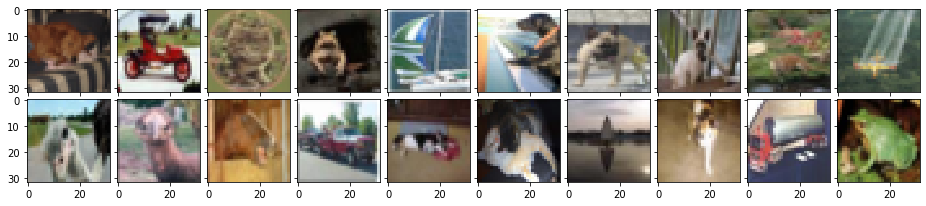

In [209]:
densenet_errors = error_by_r_score(npzfile)

In [211]:
densenet_errors

array([5830, 1969, 5511, 8728, 1772, 2525, 2804, 4614, 4965,  378, 7657,
       2592, 6151, 9227, 7509, 9431, 5548, 7099, 6741, 2405])